## Анализ убыточности развлекательного приложения Procrastinate Pro+



**Цель исследования:** Разобраться в причинах убыточности и помочь компании выйти в плюс. Так как несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

**Ход исследования:** Данные берем из трех файлов: visits_info_short.csv - лог сервера с данными об их посещениях, orders_info_short.csv - выгрузка их покупок за период и costs_info_short.csv - рекламные расходы. В файлах данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.

**Этапы исследования:**
- Загрузка и подготовка данных к анализу;
- Задать функции для расчёта и анализа LTV, ROI, удержания и конверсии;
- Исследовательский анализ;
- Маркетинг;
- Оценка окупаемости рекламы;
- Общий вывод.

**Описание данных**

Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Хорошо, что есть описание и цели проекта.
</div>

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# Загружаем данные из полученных файлов
visits, orders, costs = (
    pd.read_csv('/content/visits_info_short.csv'),  # визиты
    pd.read_csv('/content/orders_info_short.csv'),  # заказы
    pd.read_csv('/content/costs_info_short.csv'),  # расходы
)


In [3]:
# Проверяем какие данные мы получили и есть ли пропусти. Аналогично смотри все три файла.
visits.info()
visits.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [4]:
orders.info()
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [5]:
costs.info()
costs.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [6]:
# После чего проверям наличие явных дубликатов.
display(
    visits.duplicated().sum(),
    orders.duplicated().sum(),
    costs.duplicated().sum()
)

0

0

0

In [7]:
# А так же дубликтов по пользователю и дате начала сессии.
visits[['User Id', 'Session Start']].duplicated().sum()

0

In [8]:
# Так как названия столбцов не однороды проведем переименование
visits_new_column_names = {'User Id': 'user_id', 'Region': 'region', 'Device': 'device', 'Channel': 'channel', 'Session Start': 'session_start', 'Session End': 'session_end'}
orders_new_column_names = {'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'}
costs_new_column_names = {'dt': 'dt', 'Channel': 'channel', 'costs': 'costs'}
visits = visits.rename(columns = visits_new_column_names)
orders = orders.rename(columns = orders_new_column_names)
costs = costs.rename(columns = costs_new_column_names)

In [9]:
# Так как нужные нам даты находятся в формате текста перобразуме их в нужный формат.
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

**Вывод:**

После загрузки данных и проверки на пустые значения и дубликаты видим что ни того ни другого в таблицах нет. Так как названия столбцов в таблицах отличалось провели преобразование к единому стилю. А так же преобразовали даты в нужный тип данных.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [10]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC,
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [14]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [15]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

In [16]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [17]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Вывод:**

Добавлены функции для вычисления основных метрик.

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

In [18]:
# С помощью функции get_profiles получаем нужныую нам таблицу с профилями пользователей.
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt               month  payer  acquisition_cost  
0  2019-05-07 2019-05-07 20:58:57   True          1.088172  
1  2019-07-09 2019-07-09 12:46:07  False          1.107237  
2  2019-10-01 2019-10-01 09:58:33  False          0.000000  
3  2019-08-22 2019-08-22 21:35:48  False          0.988235  
4  2019-10-02 2019-10-02 00:07:44  False          0.230769

In [19]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


In [20]:
# Для проверки правильности получения минимальной и максимальной даты привлечения выведем отсортированный столбец first_ts
profiles['first_ts'].sort_values()

57600    2019-05-01 00:00:41
64627    2019-05-01 00:01:35
13003    2019-05-01 00:02:38
114484   2019-05-01 00:04:21
118717   2019-05-01 00:05:17
                 ...        
89975    2019-10-27 23:55:23
2740     2019-10-27 23:55:42
64788    2019-10-27 23:56:13
52833    2019-10-27 23:58:24
111023   2019-10-27 23:59:04
Name: first_ts, Length: 150008, dtype: datetime64[ns]

In [21]:
# С помоью функций min() и max() получим минимальную и максимальную даты привлечения
min_date = profiles['first_ts'].min()
max_date = profiles['first_ts'].max()
display(f'Минимальная дата привлечения: {min_date}',
        f'Максимальная дата привлечения: {max_date}')

'Минимальная дата привлечения: 2019-05-01 00:00:41'

'Максимальная дата привлечения: 2019-10-27 23:59:04'

In [22]:
# Для построения таблицы воспользуемся методом groupby().
# Сгруппироуем таблицу по странам и посчитаем процент платящих пользователей.
user_payed = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)
user_payed['payer'] = round(user_payed['payer'] * 100, 2)
user_payed.columns = ['count_of_user', 'persent_of_payer']
user_payed

count_of_user  persent_of_payer
region                                        
United States         100002              6.90
Germany                14981              4.11
UK                     17575              3.98
France                 17450              3.80

**Вывод:**

Видим что наибольшее количество пользователей в United States, как собственно и наибольший профент платящих польователей, почти 7%.

In [23]:
# Действуем аналогично группировки по странам.
user_device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)
user_device['payer'] = round(user_device['payer'] * 100, 2)
user_device.columns = ['count_of_user', 'persent_of_payer']
user_device

count_of_user  persent_of_payer
device                                  
Mac              30042              6.36
iPhone           54479              6.21
Android          35032              5.85
PC               30455              5.05

**Вывод:**
    
На первом месте из устройств находится Mac по количеству платящих пользователей. А просто по количеству пользователей на первом месте iPhone.

In [24]:
# Действуем аналогично группировки по странам.
user_channel = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)
user_channel['payer'] = round(user_channel['payer'] * 100, 2)
user_channel.columns = ['count_of_user', 'persent_of_payer']
user_channel

count_of_user  persent_of_payer
channel                                            
FaceBoom                    29144             12.20
AdNonSense                   3880             11.34
lambdaMediaAds               2149             10.47
TipTop                      19561              9.60
RocketSuperAds               4448              7.91
WahooNetBanner               8553              5.30
YRabbit                      4312              3.83
MediaTornado                 4364              3.57
LeapBob                      8553              3.06
OppleCreativeMedia           8605              2.71
organic                     56439              2.06

**Вывод:**
    
По источникам привлечения наибольшее количество платящих пользователей пришло из канала FaceBoom. Хотя по количеству пользователей этот канал только на втором месте. В топ три наиболее успешных канала по количеству платящих пользователей вошли: FaceBoom,  AdNonSense и  lambdaMediaAds.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [25]:
# Для того чтобы получить общую сумму расходом на маркетинг найдем сумму по столбцу costs в таблице с разходами
total_costs = round(costs['costs'].sum(),0)
total_costs

105497.0

**Вывод:**
    
Видим что общая сумма расходом на маркетинг составила 105497.

In [26]:
# Для получения нужной таблицы воспользуемся группировкой. И для большей наглядности отсортируем по убыванию.
sorted_costs_by_channel = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by = 'costs', ascending = False)
sorted_costs_by_channel['percent'] = round(sorted_costs_by_channel['costs'] / total_costs * 100,2)
sorted_costs_by_channel

costs  percent
channel                              
TipTop              54751.30    51.90
FaceBoom            32445.60    30.75
WahooNetBanner       5151.00     4.88
AdNonSense           3911.25     3.71
OppleCreativeMedia   2151.25     2.04
RocketSuperAds       1833.00     1.74
LeapBob              1797.60     1.70
lambdaMediaAds       1557.60     1.48
MediaTornado          954.48     0.90
YRabbit               944.22     0.90

**Вывод:**
    
При этом топ три канала по количеству расходов: TipTop, FaceBoom, WahooNetBanner.

In [27]:
costs_new = costs
costs_new['dt'] = pd.to_datetime(costs_new['dt'])
costs_new['week'] = costs_new['dt'].dt.isocalendar().week
costs_new['month'] = costs_new['dt'].dt.month

<ipython-input-28-2b023c66b9b3>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2, 2, 1)
<ipython-input-28-2b023c66b9b3>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(2, 2, 2, sharey=ax1)


Text(0.5, 1.0, 'Динамика изменения расходов по месяцам')

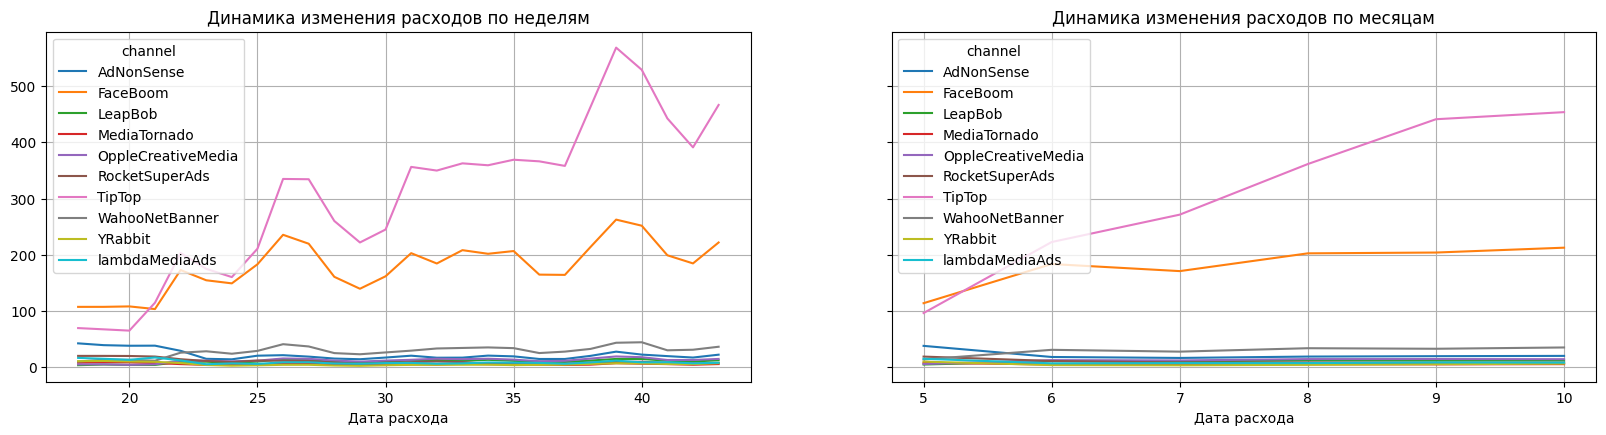

In [28]:
# Для построения графика используем plot, но первоначально соберем сводную таблицу с помощью pivot_table.
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax1 = plt.subplot(2, 2, 1)
filtered_data = costs_new.pivot_table(index='week', columns='channel', values='costs', aggfunc='mean')
filtered_data.plot(grid=True, ax=ax1)
plt.xlabel('Дата расхода')
plt.title('Динамика изменения расходов по неделям')

ax2 = plt.subplot(2, 2, 2, sharey=ax1)

filtered_data = costs_new.pivot_table(index='month', columns='channel', values='costs', aggfunc='mean')
filtered_data.plot(grid=True, ax=ax2)
plt.xlabel('Дата расхода')
plt.title('Динамика изменения расходов по месяцам')

**Вывод:**

Если посмотреть динамику расходов по датам видим что все каналы оставались примерно в одних и тех же диапазонах затрат, за исключением двух: FaceBoom - расходы вырасли в два раза и TipTop - расходы увеличились почти в пять раз. При этом по FaceBoom расходы увеличились во втором месяце и в дальнейшем остались на том же уровне. А вот расходы по TipTop увеличивались в течении пяти месяцев.

In [29]:
# Найдем среднее значение по всем каналам
round(profiles['acquisition_cost'].mean(),2)

0.7

In [30]:
# Для получения нужной таблицы воспользуемся группировкой.
# И для большей наглядности отсортируем по убыванию и округлим значение до двух знаков после запятой.
cost_for_user = profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by = 'acquisition_cost', ascending = False)
cost_for_user['acquisition_cost'] = round(cost_for_user['acquisition_cost'],2)
cost_for_user

acquisition_cost
channel                             
TipTop                          2.80
FaceBoom                        1.11
AdNonSense                      1.01
lambdaMediaAds                  0.72
WahooNetBanner                  0.60
RocketSuperAds                  0.41
OppleCreativeMedia              0.25
YRabbit                         0.22
MediaTornado                    0.22
LeapBob                         0.21
organic                         0.00

**Вывод:**
    
Видим что более 80 процентов от общего числа расходов занимают два канала TipTop и FaceBoom. Эти же каналы выделются и на графике по динамике стоимости. Так как рост стоимости был только по ним, остальные каналы оставались на одном уровне затрат. В разрезе стоимости на одного пользователя TipTop и FaceBoom так же занимают первые два места как каналы с самой высокой средней стоимостью пользователя. При этом по каналу TipTop затраты на пользователя в 4 раза выше средней.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [31]:
# Чтобы исключить пользователей с органического трафика отфильтруем таблицу профилей
filtered_profiles = profiles[profiles['channel'] != 'organic']
filtered_profiles

user_id            first_ts       channel   device  \
0             599326 2019-05-07 20:58:57      FaceBoom      Mac   
1            4919697 2019-07-09 12:46:07      FaceBoom   iPhone   
3           22593348 2019-08-22 21:35:48    AdNonSense       PC   
4           31989216 2019-10-02 00:07:44       YRabbit   iPhone   
7           46006712 2019-06-30 03:46:29    AdNonSense  Android   
...              ...                 ...           ...      ...   
149999  999942424543 2019-05-24 21:03:26        TipTop   iPhone   
150001  999949280903 2019-08-12 06:47:27      FaceBoom      Mac   
150003  999956196527 2019-09-28 08:33:02        TipTop   iPhone   
150005  999976332130 2019-07-23 02:57:06        TipTop   iPhone   
150006  999979924135 2019-09-28 21:28:09  MediaTornado       PC   

               region          dt               month  payer  acquisition_cost  
0       United States  2019-05-07 2019-05-07 20:58:57   True          1.088172  
1       United States  2019-07-09 2019-07-09 12:46:07  False          1.107237  
3             Germany  2019-08-22 2019-08-22 21:35:48  False          0.988235  
4       United States  2019-10-02 2019-10-02 00:07:44  False          0.230769  
7              France  2019-06-30 2019-06-30 03:46:29   True          1.008000  
...               ...         ...                 ...    ...               ...  
149999  United States  2019-05-24 2019-05-24 21:03:26  False          1.900000  
150001  United States  2019-08-12 2019-08-12 06:47:27  False          1.117838  
150003  United States  2019-09-28 2019-09-28 08:33:02  False          3.500000  
150005  United States  2019-07-23 2019-07-23 02:57:06  False          2.600000  
150006  United States  2019-09-28 2019-09-28 21:28:09  False          0.205714  

[93569 rows x 9 columns]

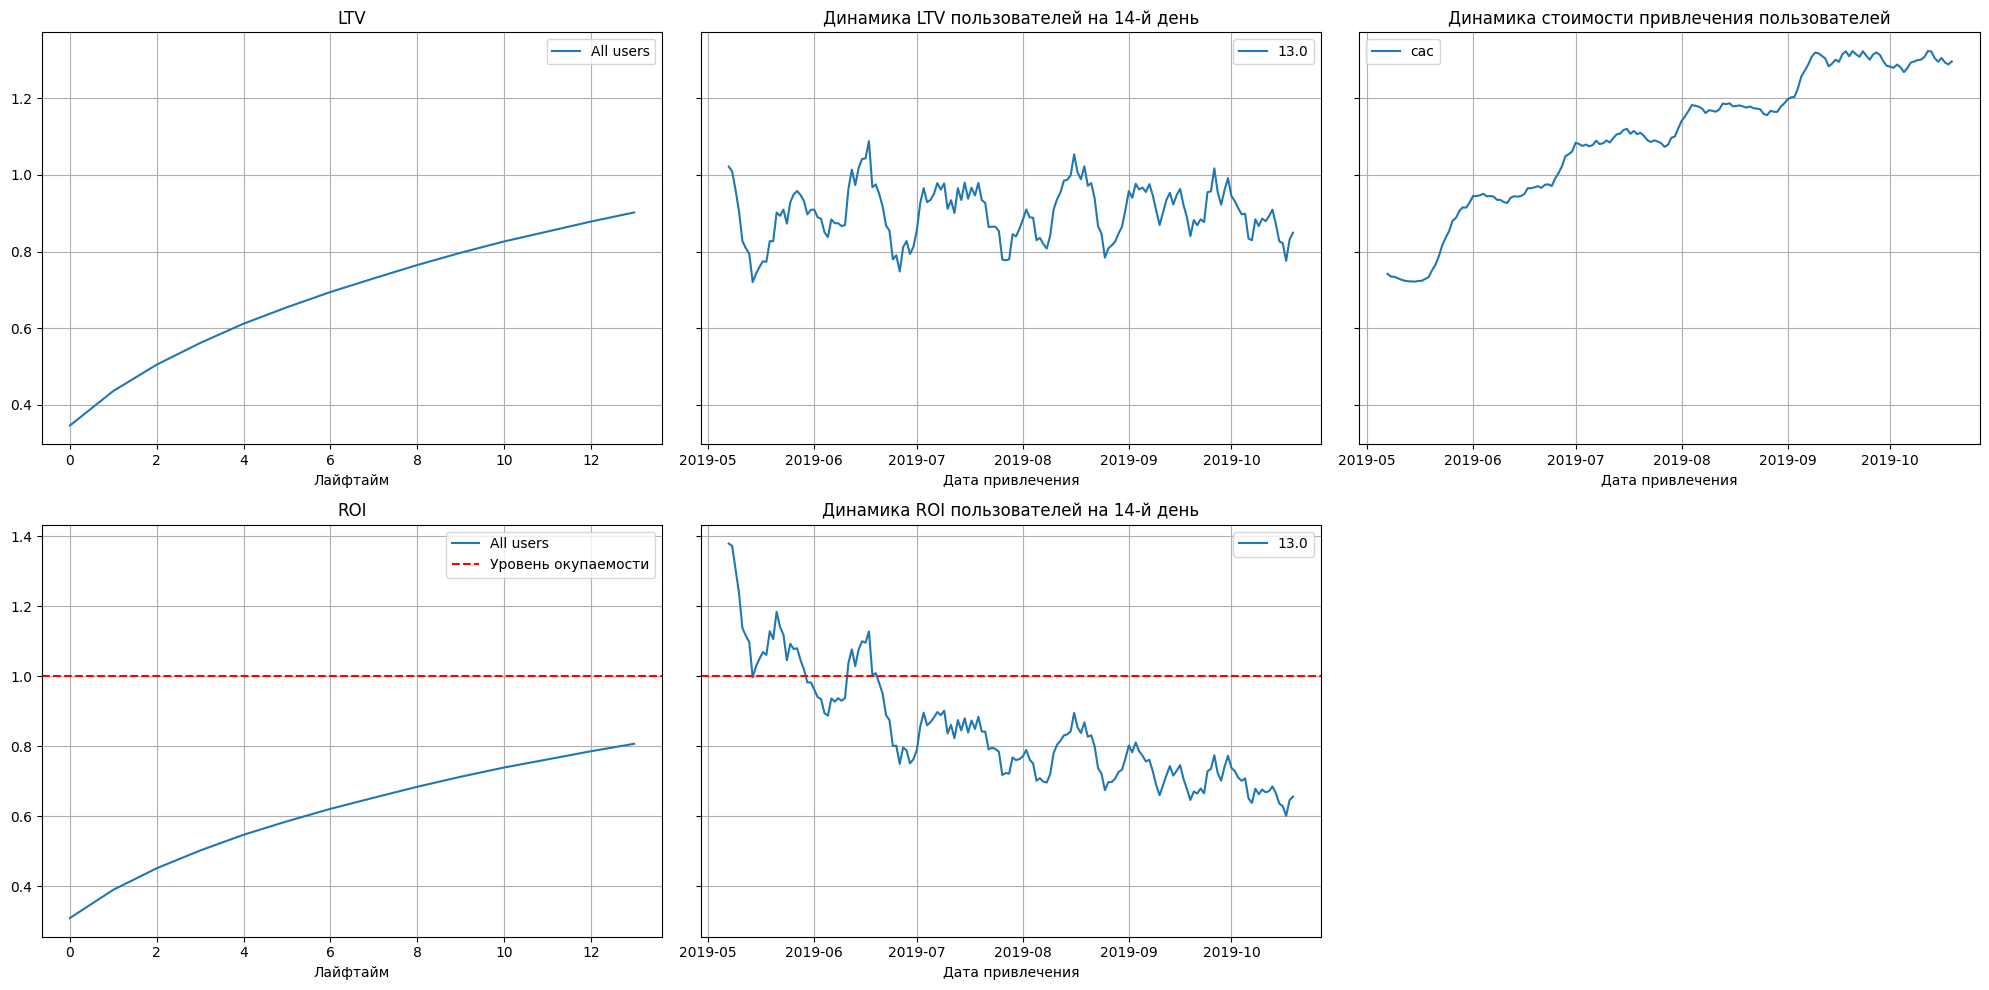

In [32]:
# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с помощью функций.
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Выводы**

Реклама не окупается. Видим что на 14 день окупаемость рекламы около 80%
САС при этом возрастает, что говорит об увеличении рекламного бюджета.
LTV достаточно стабилет. А вот ROI на 14 день падает, что говорит о снижении окупаемости.

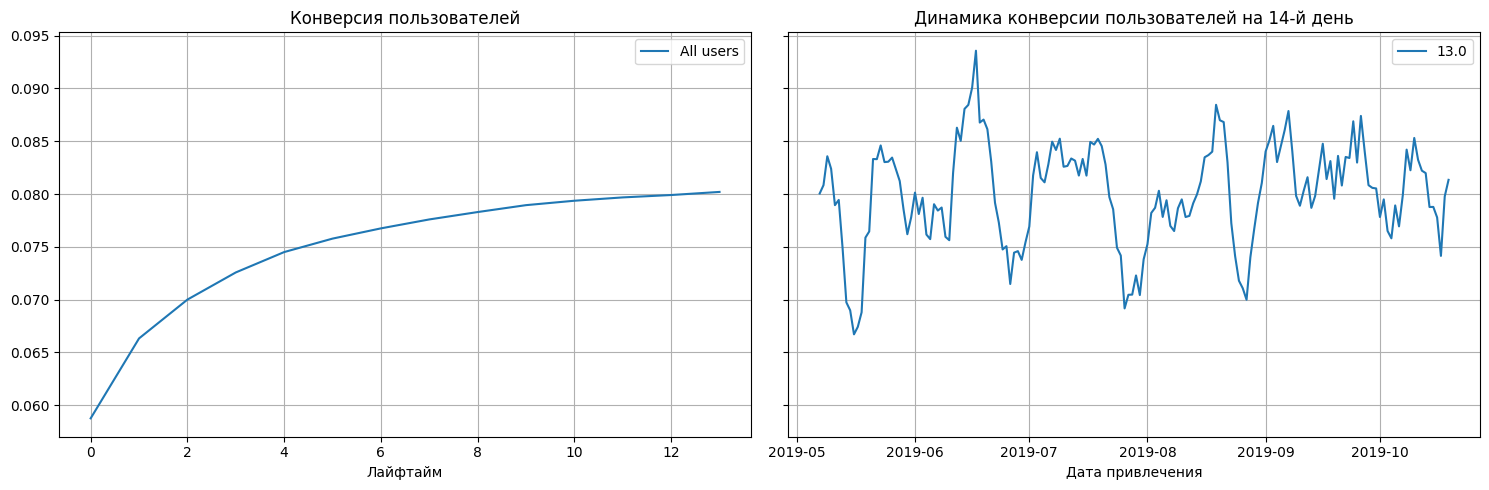

In [33]:
# Построим графики конверсии и удержания
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

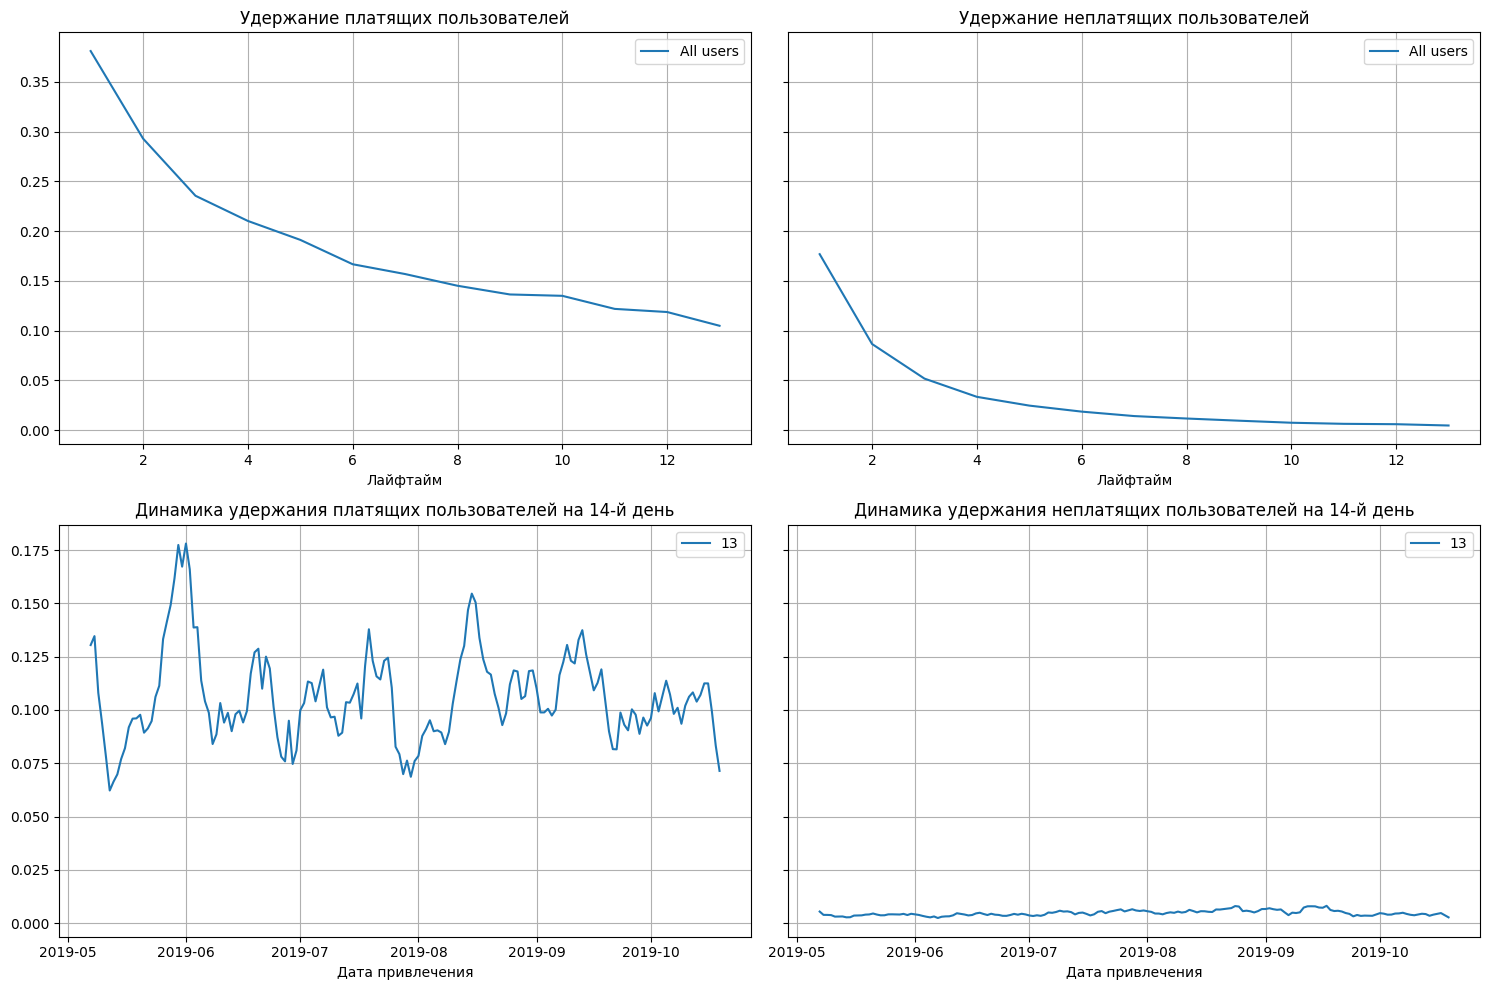

In [34]:
retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод**

В целом с конверсией все в порядке, имеется восходящий тренд.
На общем графике удержания так же не наблюдается каких-то аномальных значений. Динамика платящих пользователей достаточно стабильна.

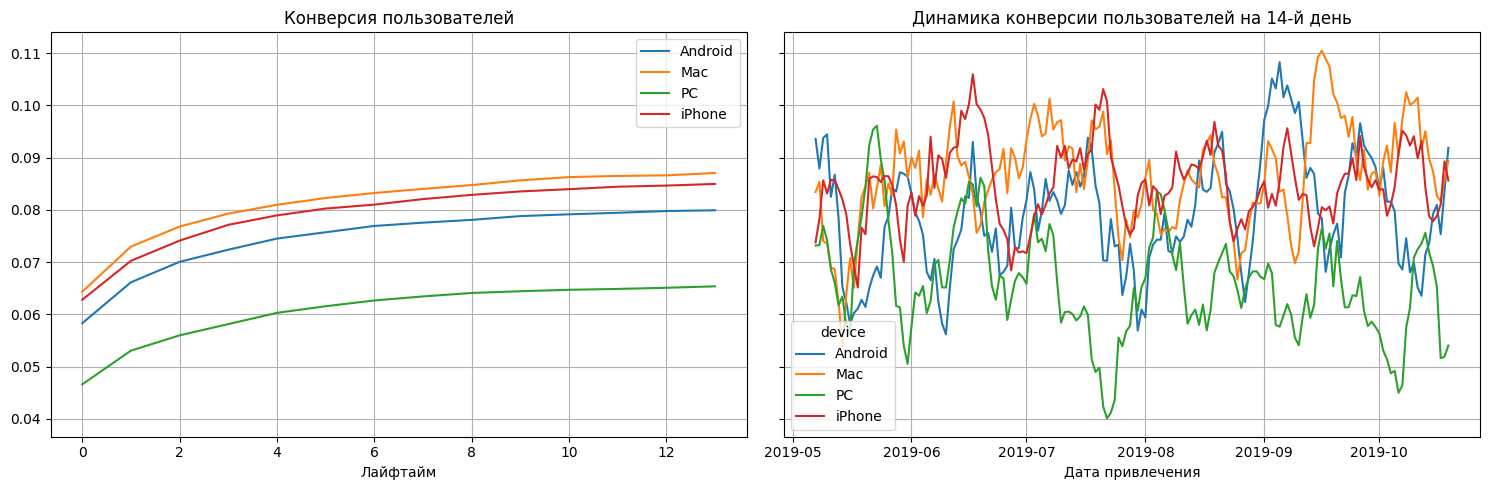

In [35]:
# Построим графики конверсии и удержания с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

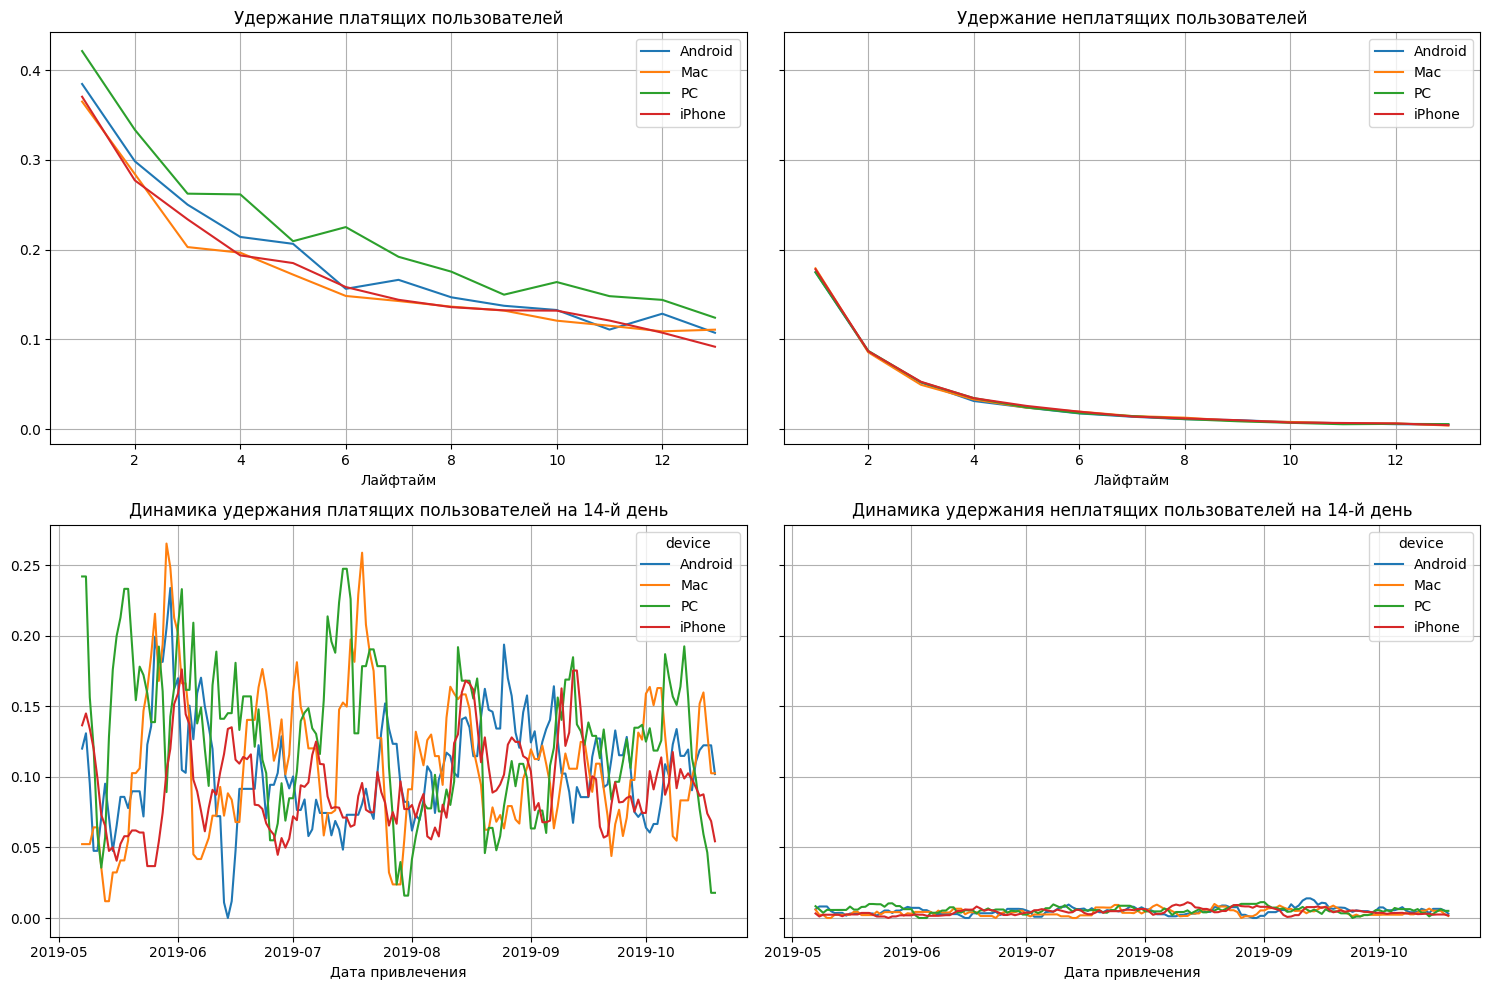

In [36]:
retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**

Если рассматривать конверсию в разрезе устройств видим, что лучше всего конверсия у MAC и iPhone. А вот удержание не настолько выделяется, так как по этим устройствам удержание хуже всех остальных устройств.

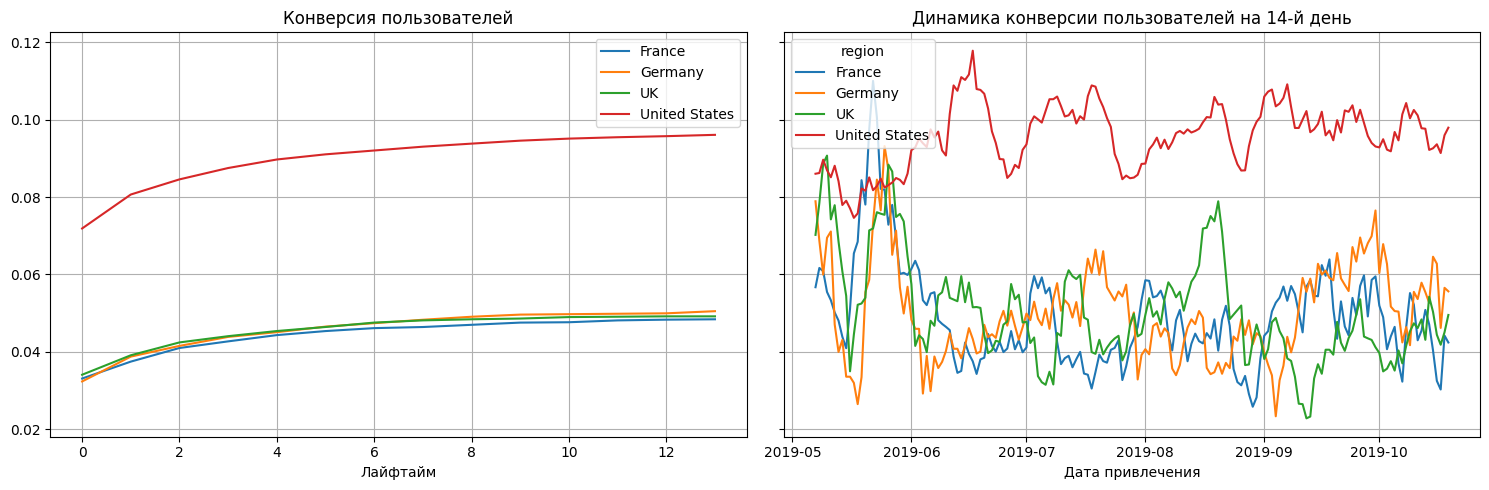

In [37]:
# Построим графики конверсии и удержания с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

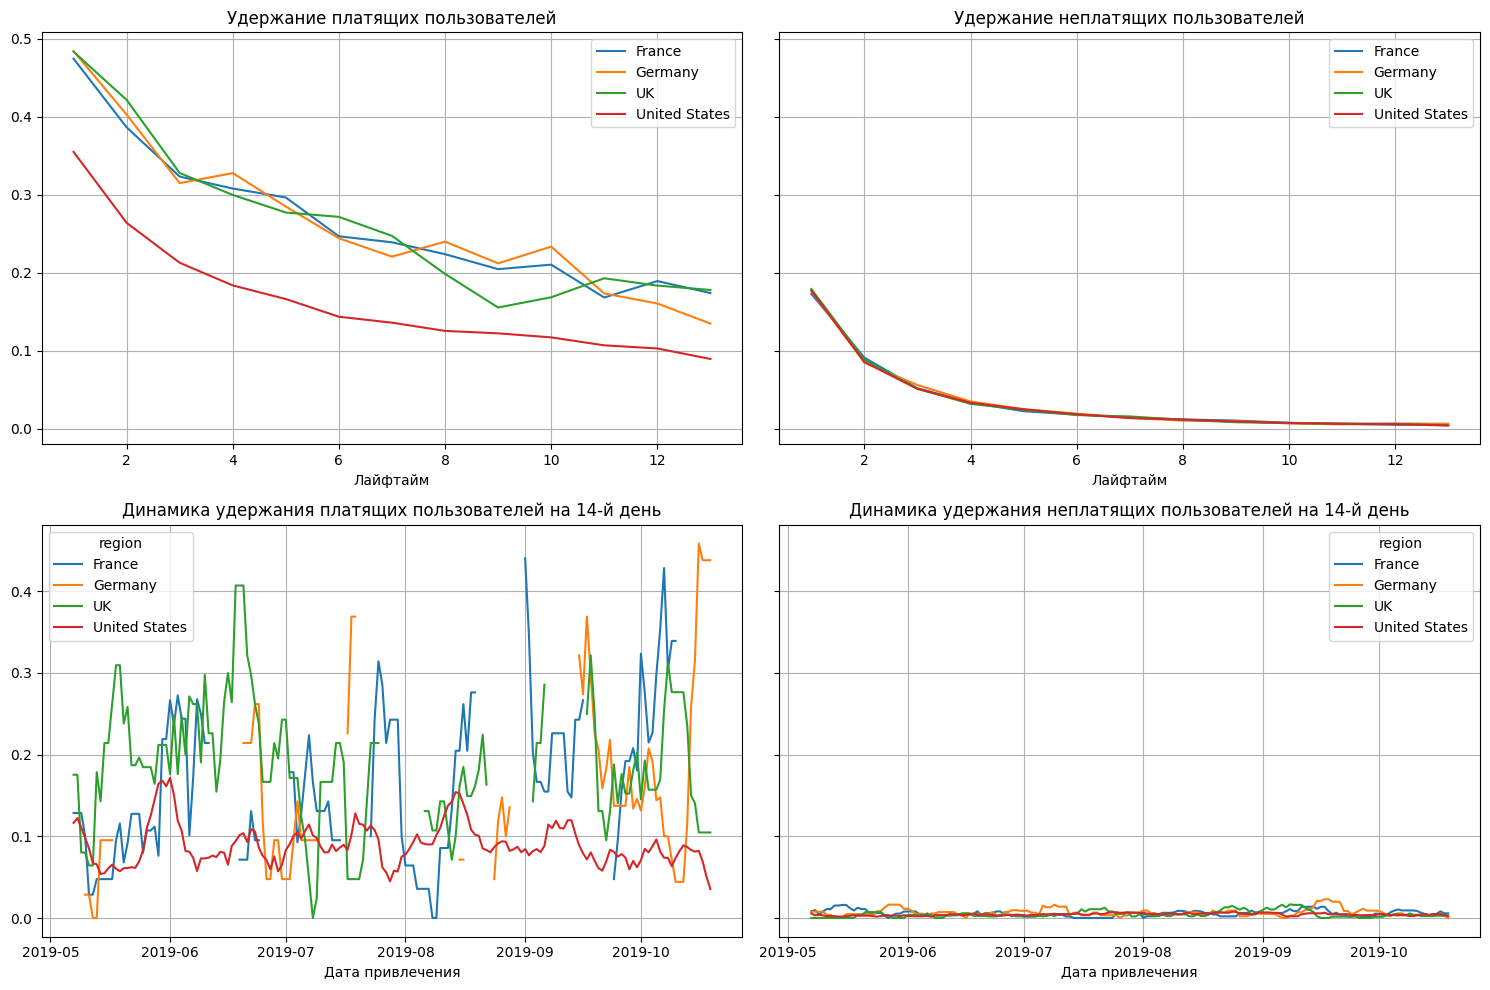

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**

При разбивке по странам видим, что по конверсии лидирует United States, хотя при этом страна имеет самое худшее удержание.

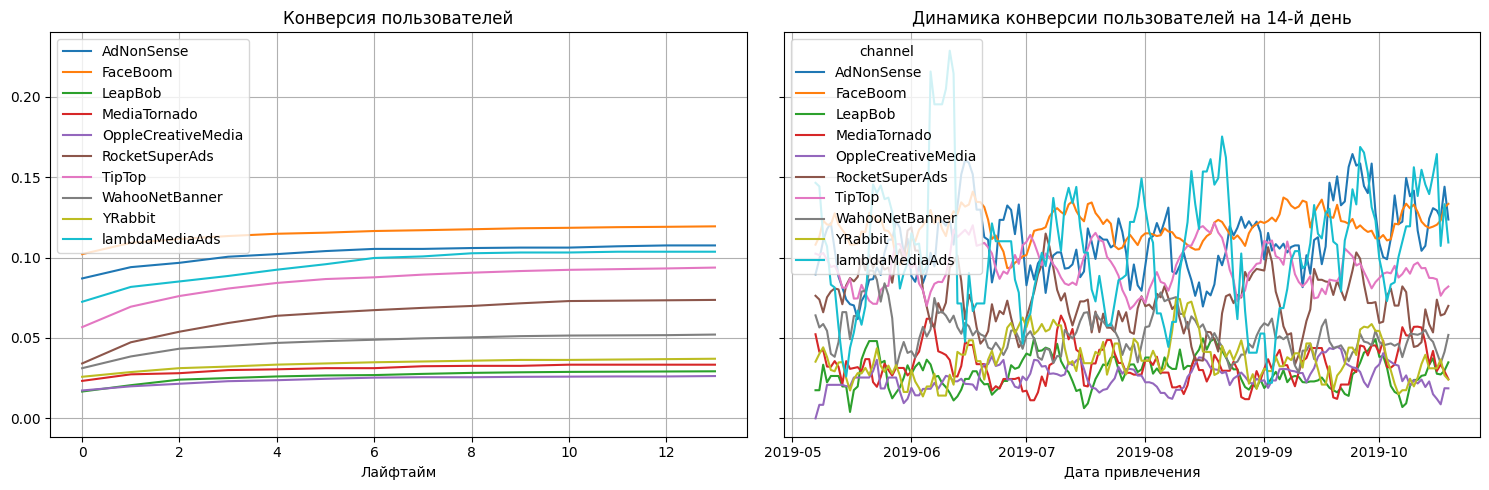

In [39]:
# Построим графики конверсии и удержания с разбивкой по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

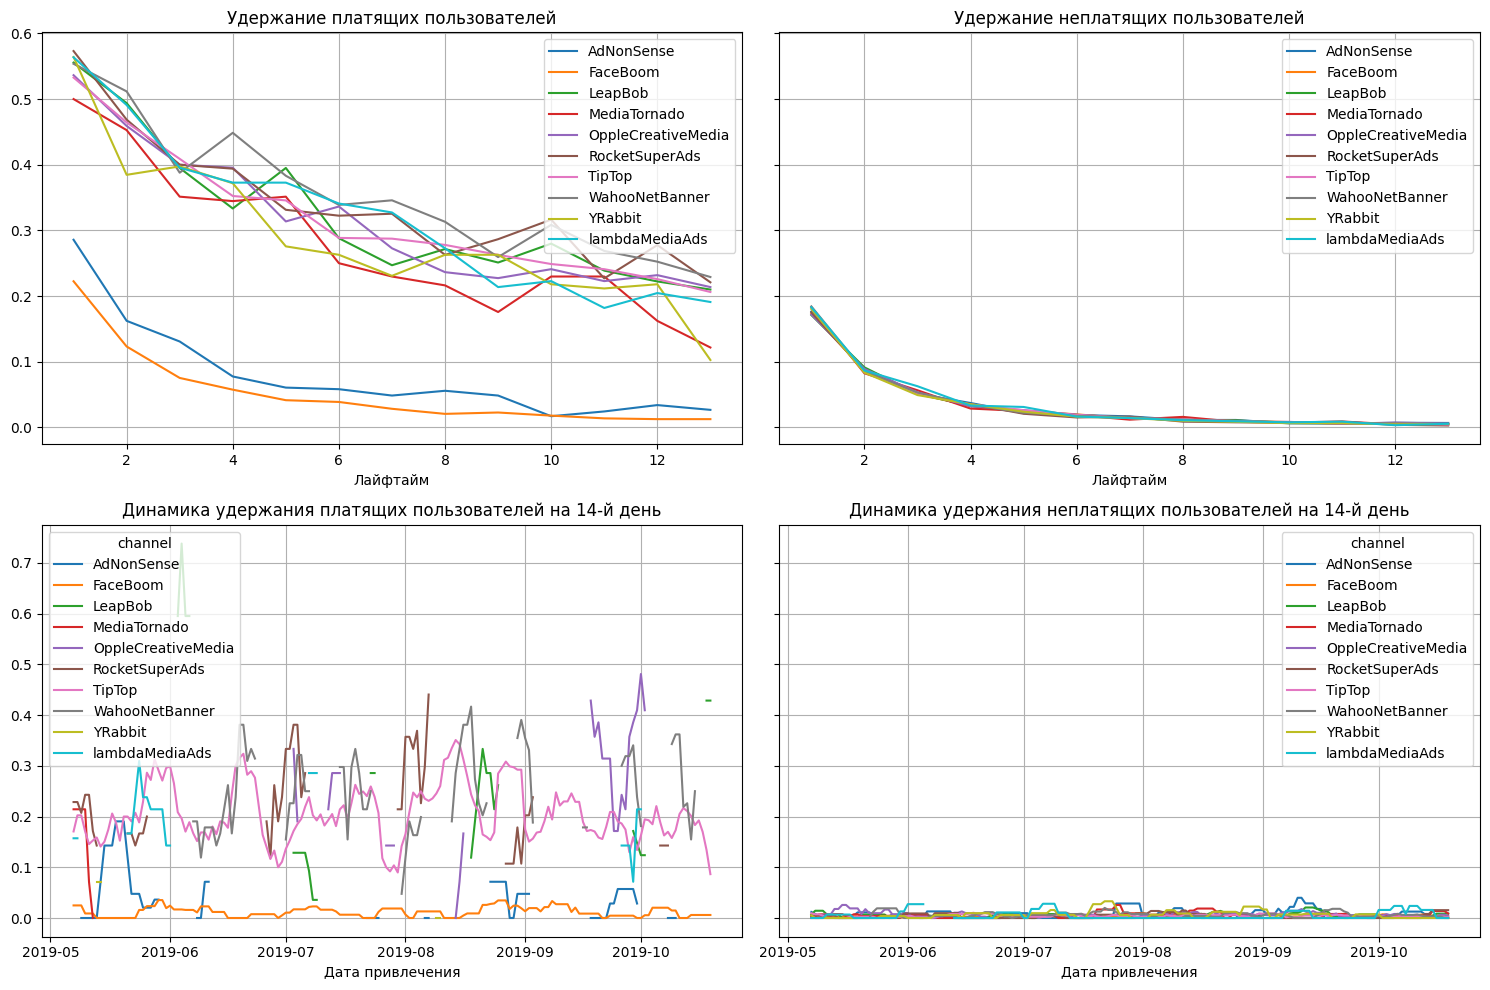

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**

Если смотреть на показатели конверсии и удержания по каналам видим, что лучше всего конверсия у каналов FaceBoom и AdNonSense. А вот удержание по ним самое худшее. При этом если посмотреть динамику удержания на 14 день для FaceBoom она стабильно находится около нуля.

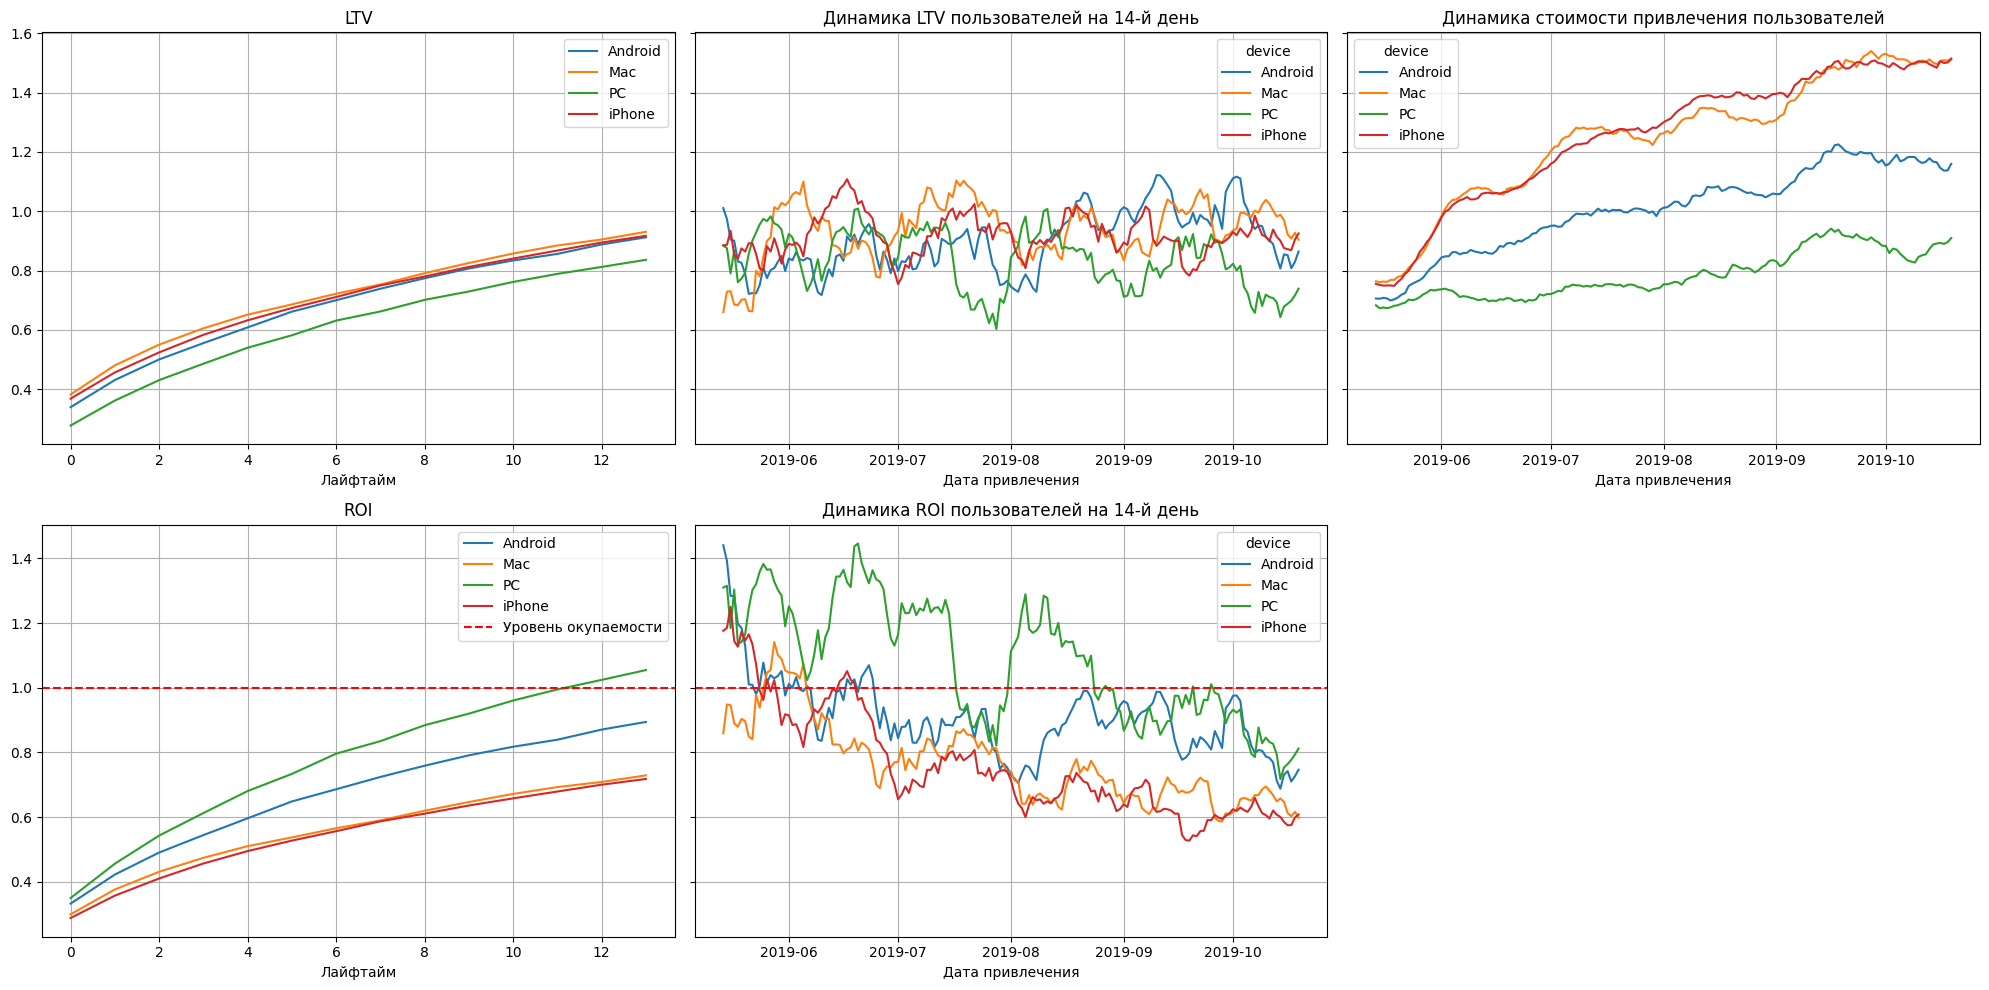

In [41]:
# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с помощью функций.
# Только в этот раз проведем разбивку по устройствам.
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод**

В разбивке по устройствам, пользователи РС стабильно окупаются, а вот Мас, iPhone и Android нет. При этом видим что больше всего возрасла стоимость привлечения именно пользователей Мас и iPhone. Так же был рост стоимости Android.

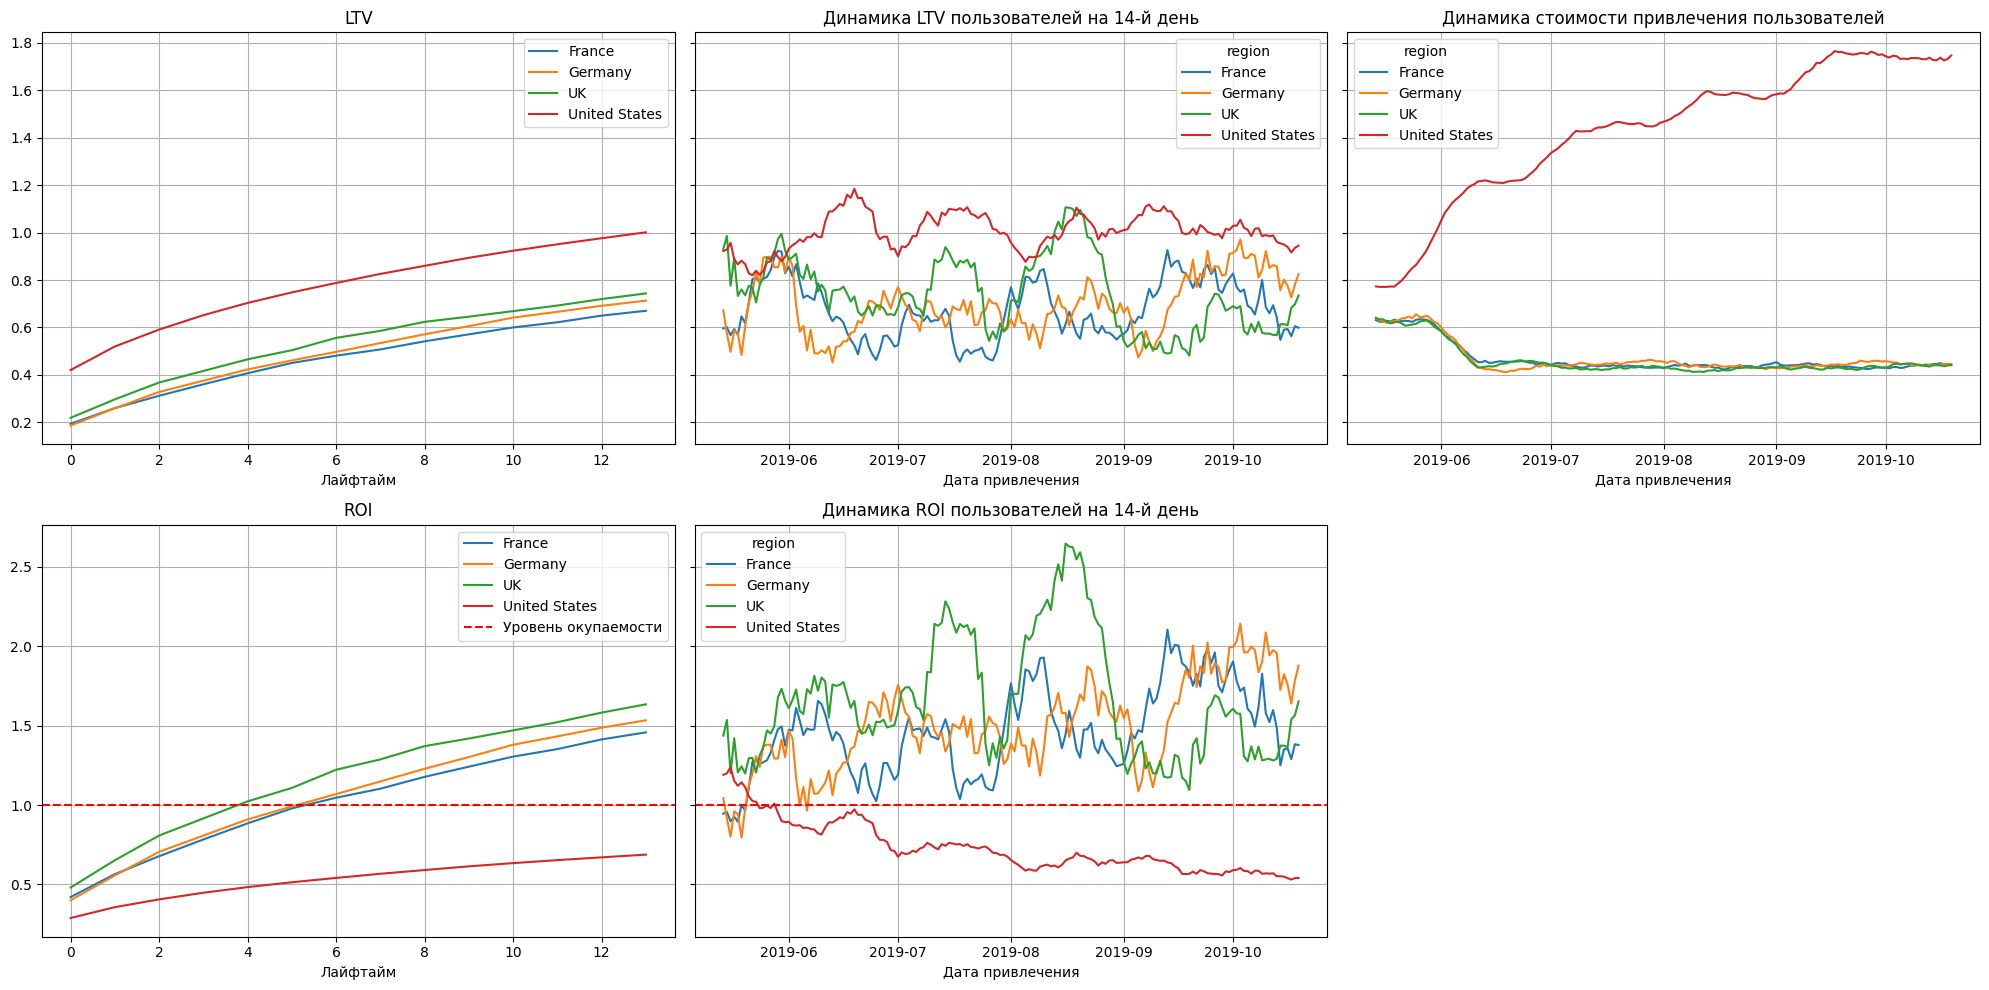

In [42]:
# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с помощью функций.
# Только в этот раз проведем разбивку по странам.
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод**

В разбивке по странам видим, что реклама не окупается только в United States. При этом стоимость рекламы возросла так же только в этой стране, при том что в остальных стоимость привлечения осталась даже снижалась.

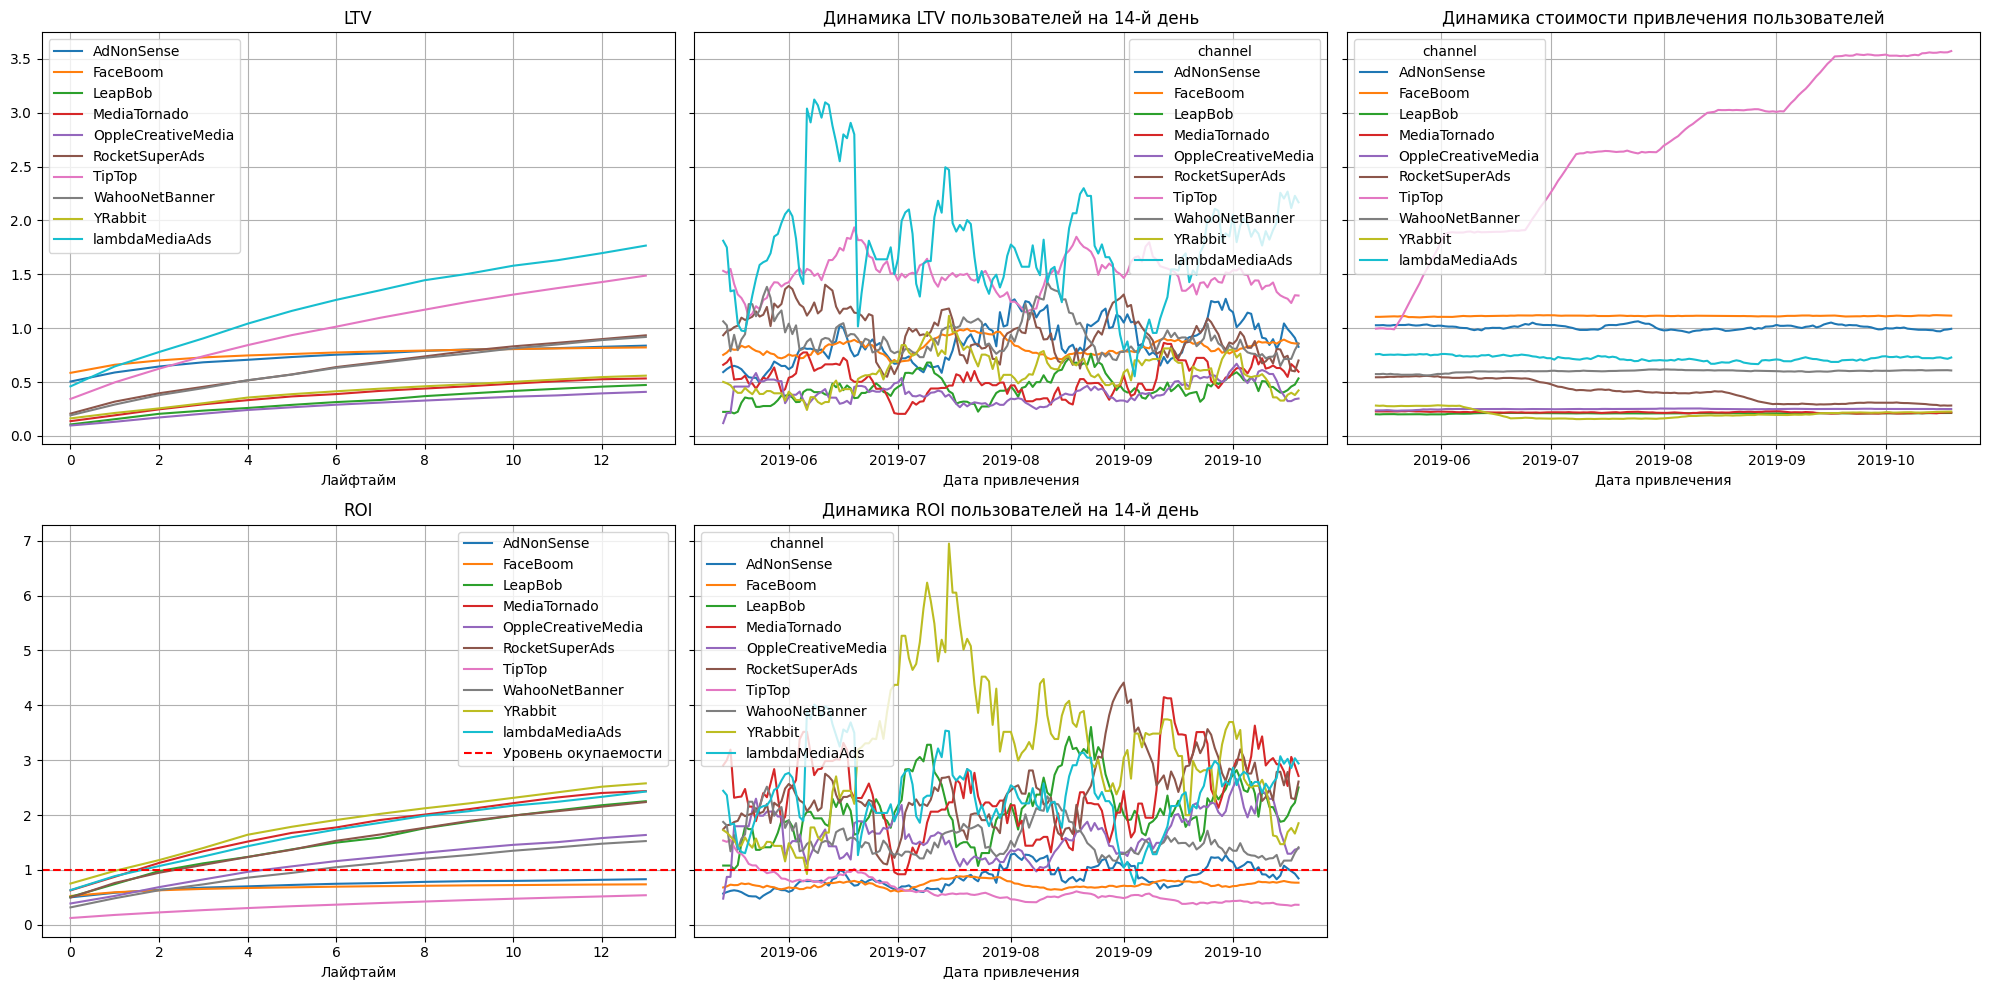

In [43]:
# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с помощью функций.
# Только в этот раз проведем разбивку по рекламным каналам.
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод**

А вот в разбивке по каналам видим, что не окупаются лидеры по стоимости вложений: TipTop, FaceBoom, а так же AdNonSense. При этом стоисмость привлечения пользователя росла только у одного канала - TipTop.

#### United States

In [44]:
# Посмотрим на показатели по United States. Для этого отфильтруем таблицу по стране.
filtered_profiles_us = filtered_profiles[filtered_profiles['region'] == 'United States']
filtered_profiles_us

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
8           58263264 2019-05-11 19:18:43      FaceBoom  iPhone  United States   
9           59835779 2019-05-11 21:13:47  MediaTornado  iPhone  United States   
...              ...                 ...           ...     ...            ...   
149999  999942424543 2019-05-24 21:03:26        TipTop  iPhone  United States   
150001  999949280903 2019-08-12 06:47:27      FaceBoom     Mac  United States   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   

                dt               month  payer  acquisition_cost  
0       2019-05-07 2019-05-07 20:58:57   True          1.088172  
1       2019-07-09 2019-07-09 12:46:07  False          1.107237  
4       2019-10-02 2019-10-02 00:07:44  False          0.230769  
8       2019-05-11 2019-05-11 19:18:43  False          1.128205  
9       2019-05-11 2019-05-11 21:13:47  False          0.250435  
...            ...                 ...    ...               ...  
149999  2019-05-24 2019-05-24 21:03:26  False          1.900000  
150001  2019-08-12 2019-08-12 06:47:27  False          1.117838  
150003  2019-09-28 2019-09-28 08:33:02  False          3.500000  
150005  2019-07-23 2019-07-23 02:57:06  False          2.600000  
150006  2019-09-28 2019-09-28 21:28:09  False          0.205714  

[61829 rows x 9 columns]

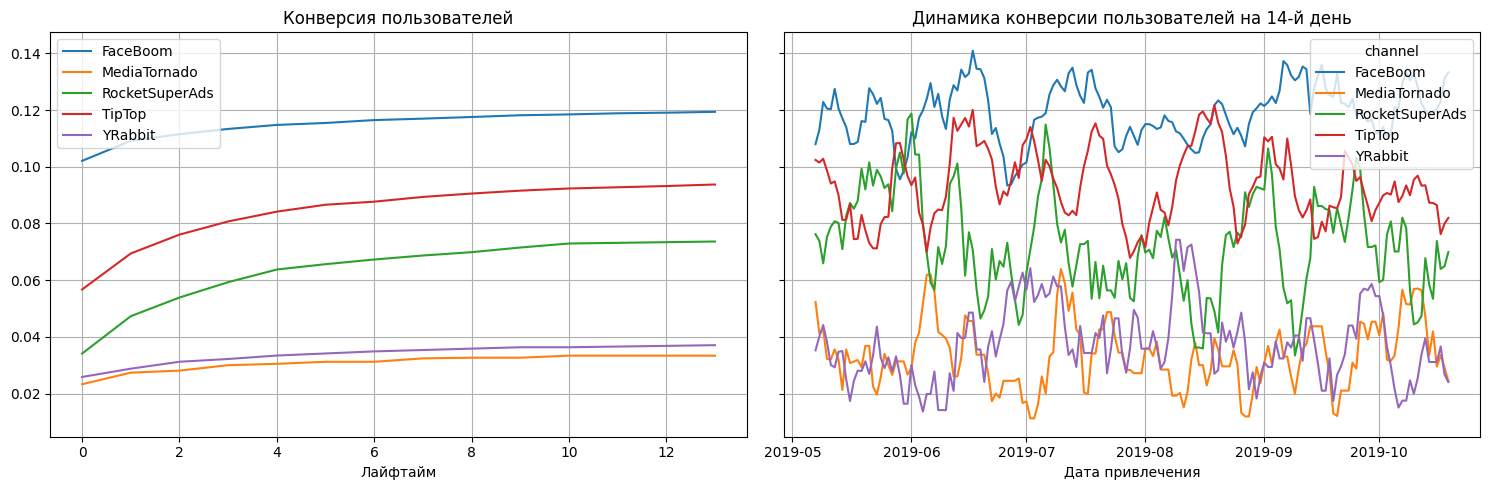

In [45]:
# Построим графики конверсии и удержания с разбивкой по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

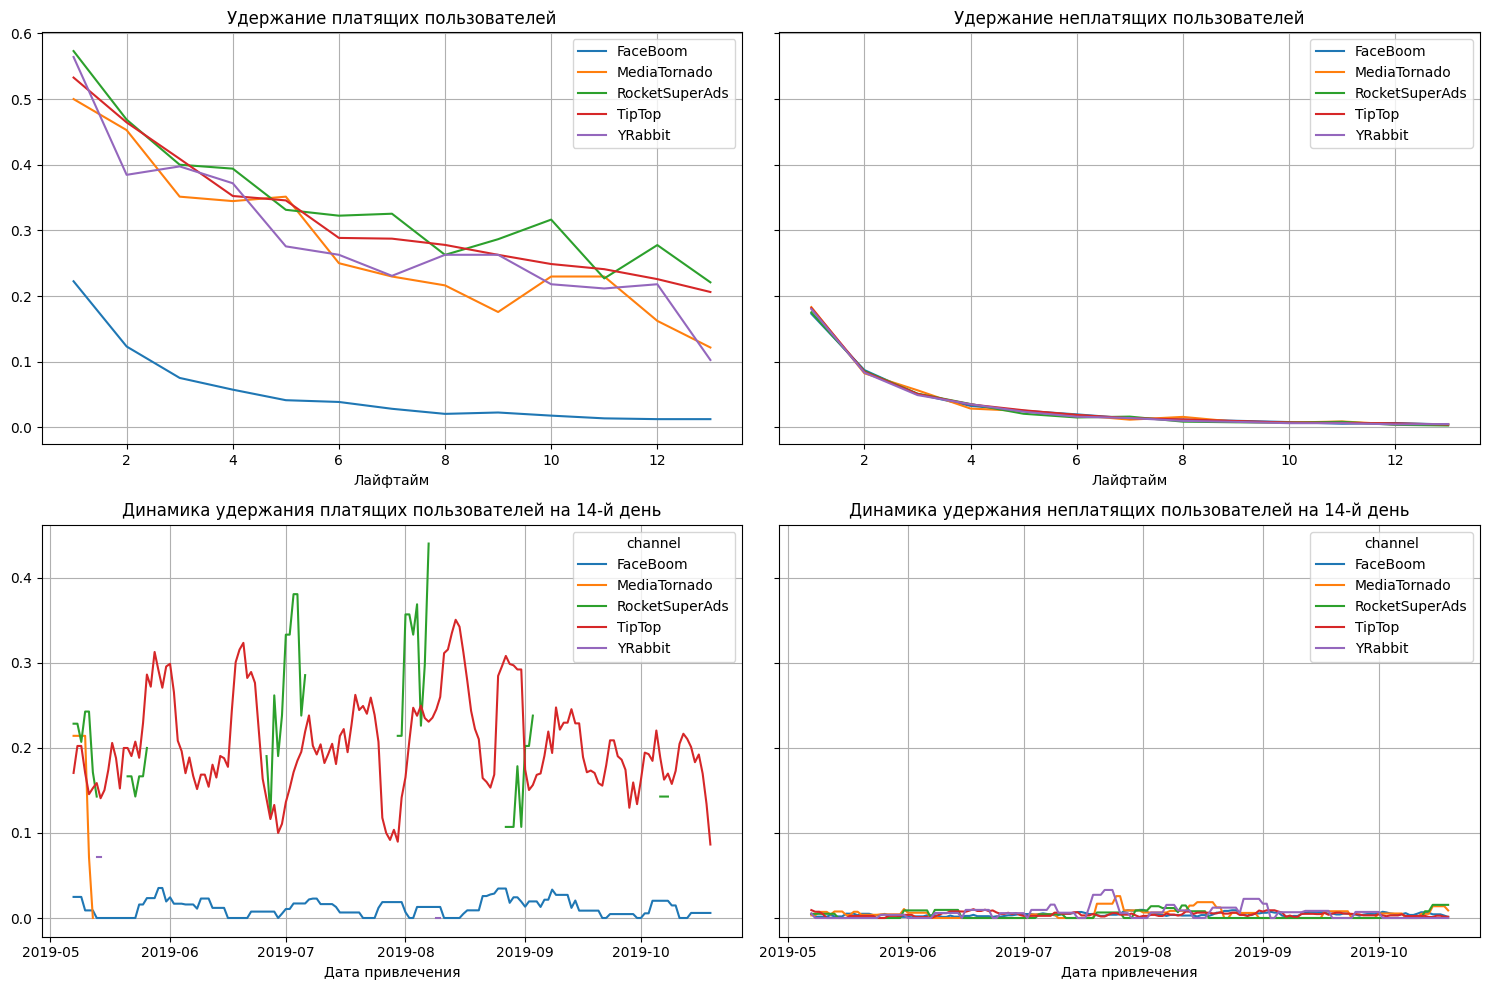

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles_us, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

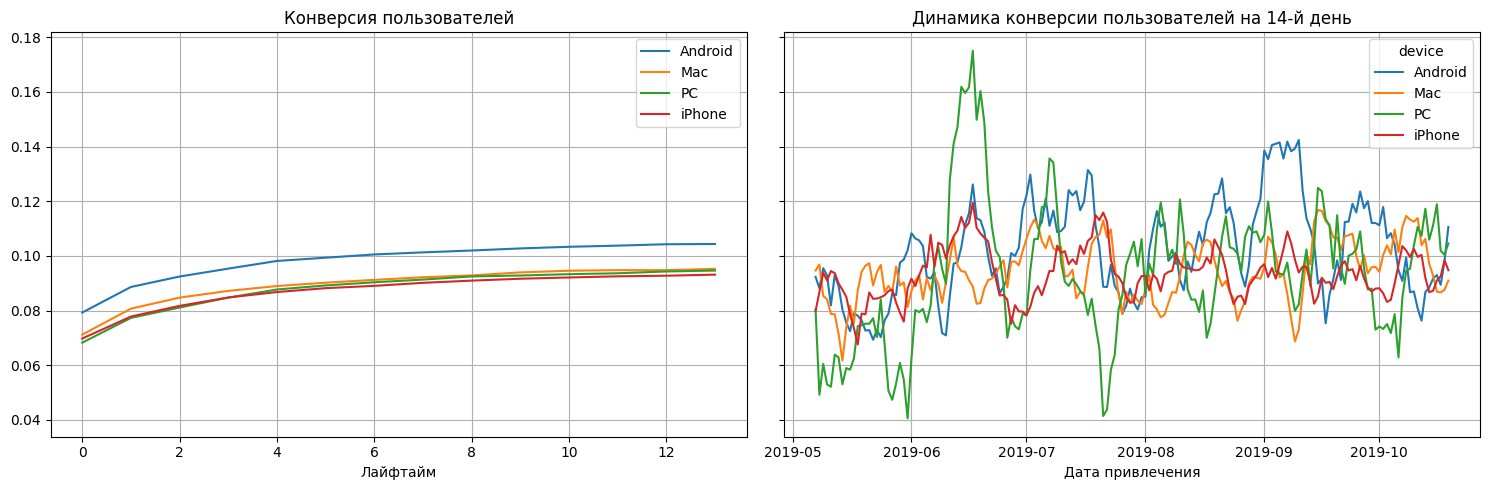

In [47]:
# Построим графики конверсии и удержания с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

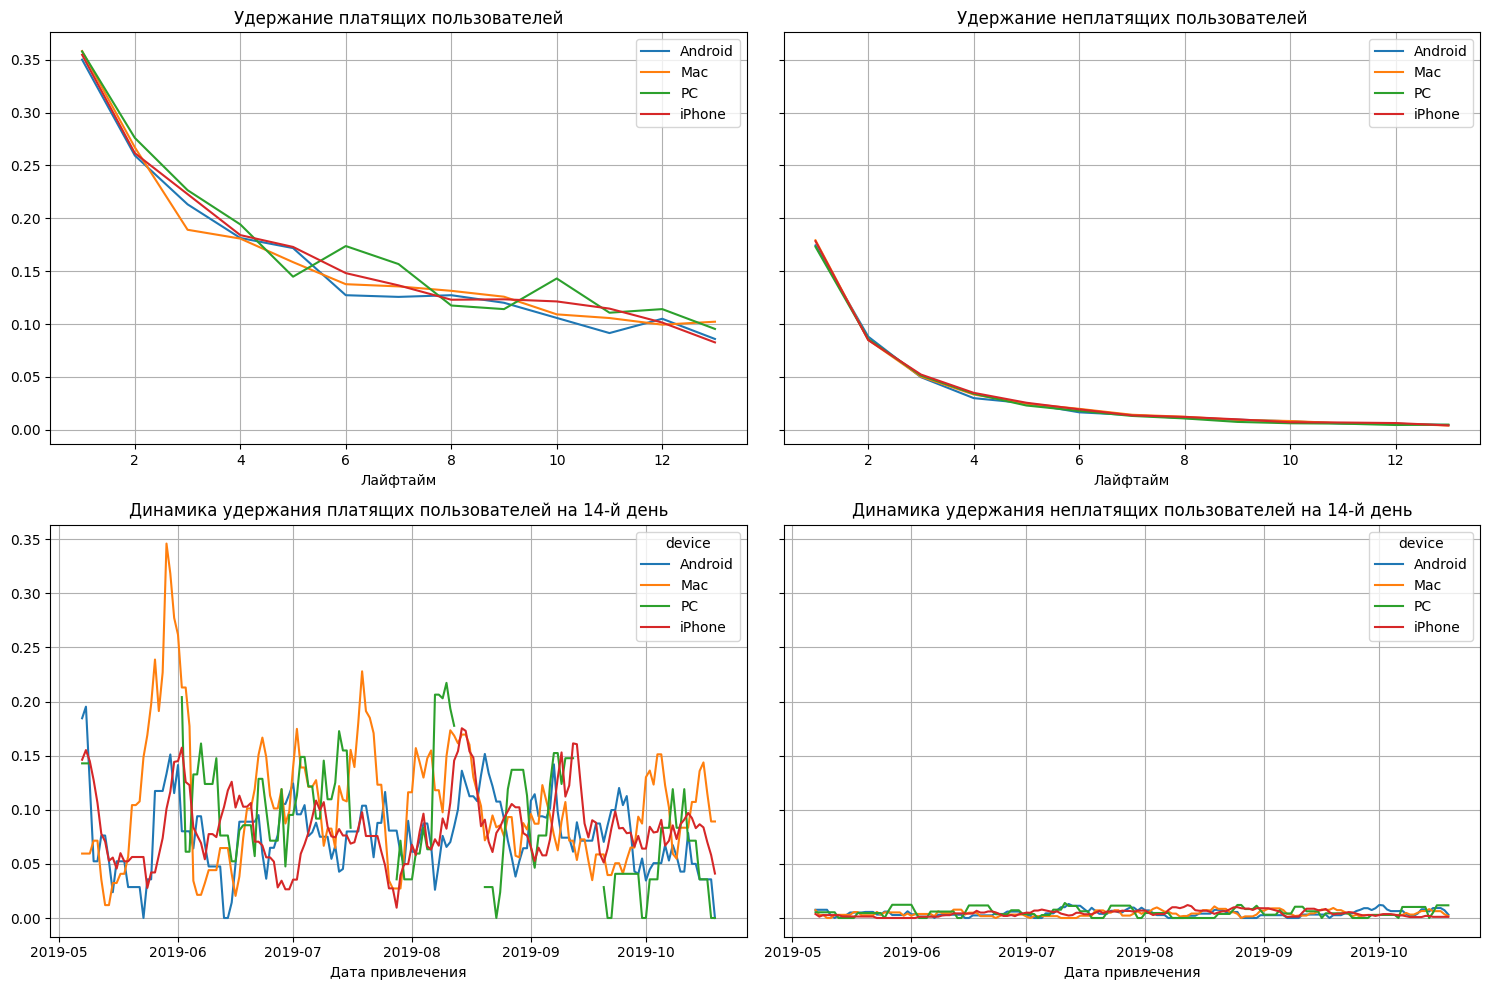

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles_us, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

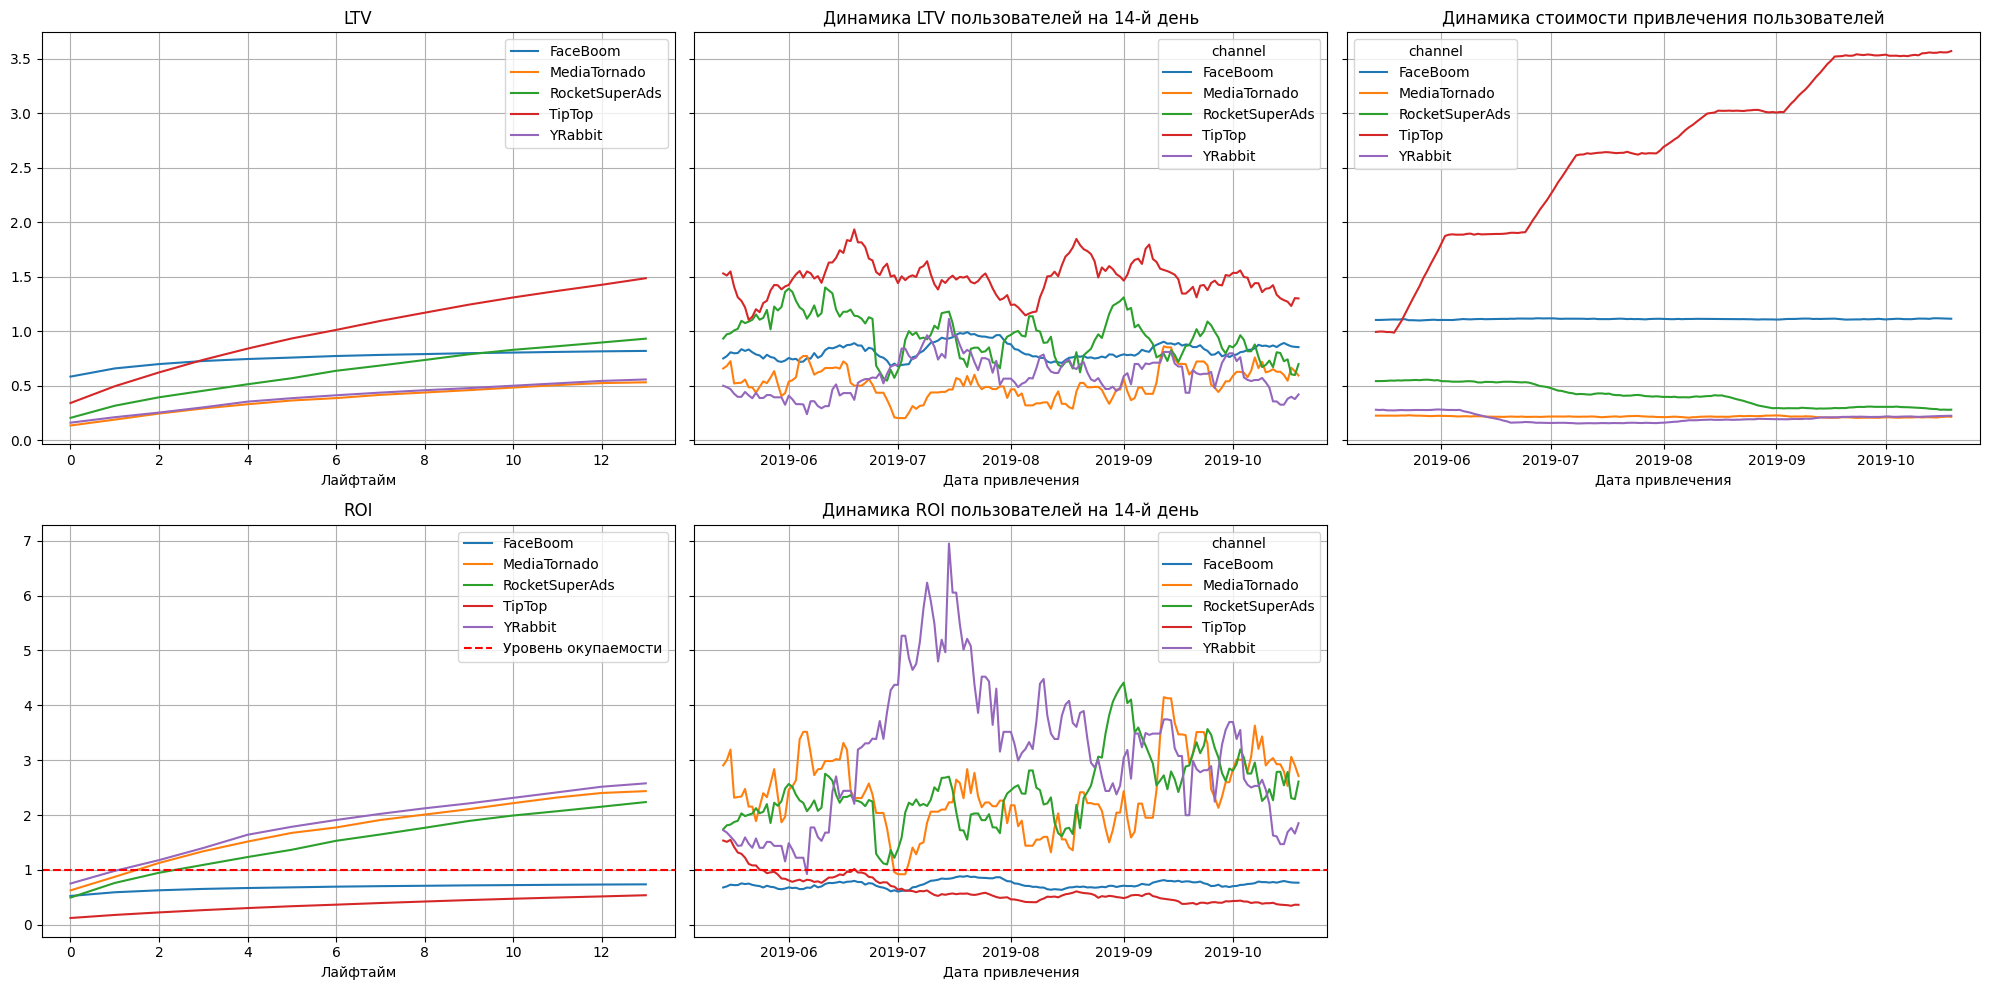

In [49]:
# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с помощью функций.
# Только в этот раз проведем разбивку по рекламным каналам.
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

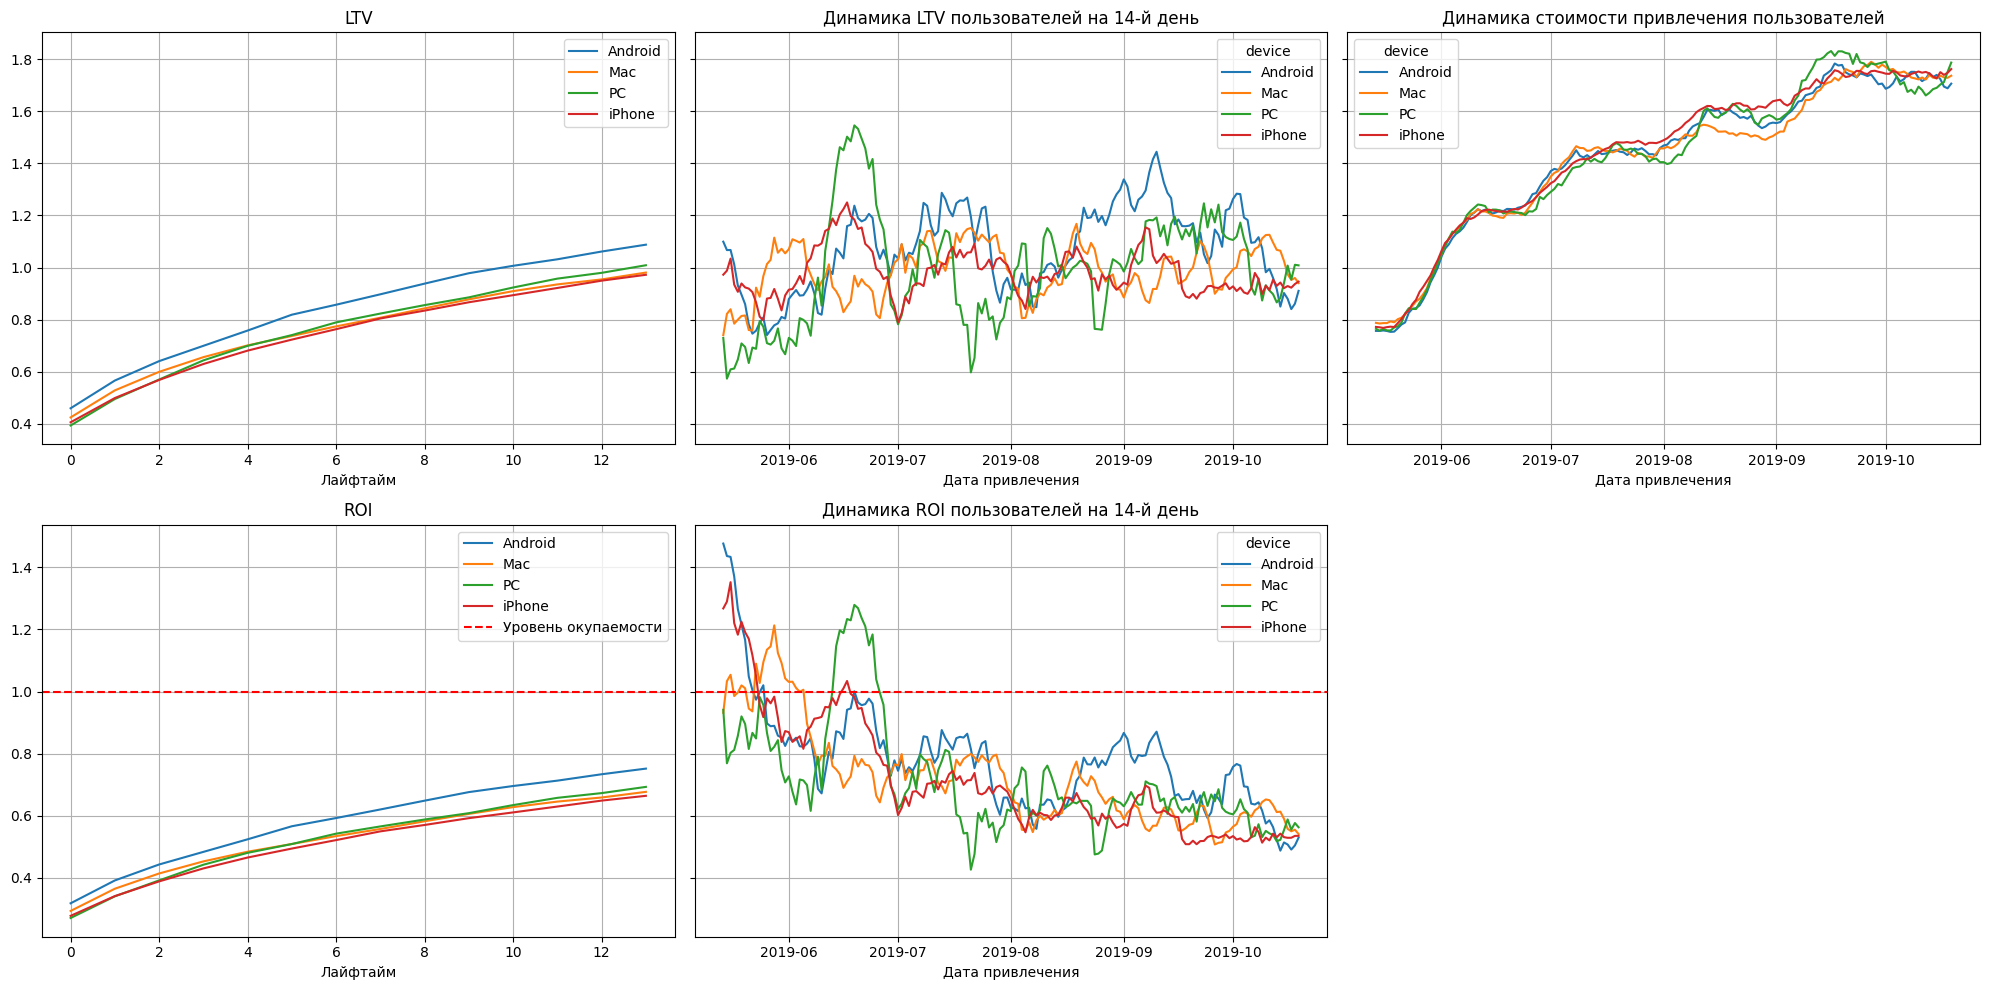

In [50]:
# Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с помощью функций.
# Только в этот раз проведем разбивку по устройствам.
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Вывод по United States:**

В разрезе United States видим что хуже всего конверсия у MediaTornado и YRabbit. При этому лучшая конверсия у FaceBoom. В тоже время худшее удержание у того же FaceBoom.

В разбивке по устройствам в лидерах Android, а вот по удержанию все устройства примерно равны.

Что касается окупаемости рекламы не окупаются только два канала FaceBoom и TipTop. При этом стоимость размещения росла больше всего у TipTop.

А вот с окупаемостью устройств все хуже, так как окупаемость по всем находится в районе 70%. Так же стоит отметить рост затрат на рзмещение по всем устройствам.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

**Общий вывод**

*1.3 Исследовательский анализ данных:*

- Видим что наибольшее количество пользователей в United States, как собственно и наибольший профент платящих польователей, почти 7%.
- На первом месте из устройств находится Mac по количеству платящих пользователей. А просто по количеству пользователей на первом месте iPhone.
- По источникам привлечения наибольшее количество платящих пользователей пришло из канала FaceBoom. Хотя по количеству пользователей этот канал только на втором месте. В топ три наиболее успешных канала по количеству платящих пользователей вошли: FaceBoom, AdNonSense и lambdaMediaAds

*1.4 Маркетинг:*

- Общая сумма расходом на маркетинг составила 105497.
- Видим что более 80 процентов от общего числа расходов занимают два канала TipTop и FaceBoom. Эти же каналы выделются и на графике по динамике стоимости. Так как рост стоимости был только по ним, остальные каналы оставались на одном уровне затрат. В разрезе стоимости на одного пользователя TipTop и FaceBoom так же занимают первые два места как каналы с самой высокой средней стоимостью пользователя. При этом по каналу TipTop затраты на пользователя в 4 раза выше средней.

*1.5 Окупаемость рекламы:*

- Реклама не окупается. Видим что на 14 день окупаемость рекламы около 80% САС при этом возрастает, что говорит об увеличении рекламного бюджета. LTV достаточно стабилет. А вот ROI на 14 день падает, что говорит о снижении окупаемости.
- В целом с конверсией все в порядке, имеется восходящий тренд. На общем графике удержания так же не наблюдается каких-то аномальных значений. Динамика платящих пользователей достаточно стабильна.
- Если рассматривать конверсию в разрезе устройств видим, что лучше всего конверсия у MAC и iPhone. А вот удержание не настолько выделяется, так как по этим устройствам удержание хуже всех остальных устройств.
- При разбивке по странам видим, что по конверсии лидирует United States, хотя при этом страна имеет самое худшее удержание.
- Если смотреть на показатели конверсии и удержания по каналам видим, что лучше всего конверсия у каналов FaceBoom и AdNonSense. А вот удержание по ним самое худшее. При этом если посмотреть динамику удержания на 14 день для FaceBoom она стабильно находится около нуля.
- В разбивке по устройствам, пользователи РС стабильно окупаются, а вот Мас, iPhone и Android нет. При этом видим что больше всего возрасла стоимость привлечения именно пользователей Мас и iPhone. Так же был рост стоимости Android.
- В разбивке по странам видим, что реклама не окупается только в United States. При этом стоимость рекламы возросла так же только в этой стране, при том что в остальных стоимость привлечения осталась даже снижалась.
- А вот в разбивке по каналам видим, что не окупаются лидеры по стоимости вложений: TipTop, FaceBoom, а так же AdNonSense. При этом стоисмость привлечения пользователя росла только у одного канала - TipTop.

*1.5.1 United States:*

- В разрезе United States видим что хуже всего конверсия у MediaTornado и YRabbit. При этому лучшая конверсия у FaceBoom. В тоже время худшее удержание у того же FaceBoom.
- В разбивке по устройствам в лидерах Android, а вот по удержанию все устройства примерно равны.
- Что касается окупаемости рекламы не окупаются только два канала FaceBoom и TipTop. При этом стоимость размещения росла больше всего у TipTop.
- А вот с окупаемостью устройств все хуже, так как окупаемость по всем находится в районе 70%. Так же стоит отметить рост затрат на рзмещение по всем устройствам.


**Причины неэффективности привлечения пользователей**

1) Одна из основных причин неэффективности состоит в том что основные средства вкладываются в направления с наибольшей конверсией, но при этом с очень плохим удержанием. Что подтверждается графиками на которых видим:
- При разбивке по странам видим, что по конверсии лидирует United States, хотя при этом страна имеет самое худшее удержание;
- лучше всего конверсия у каналов FaceBoom и AdNonSense. А вот удержание по ним самое худшее;
- Если рассматривать конверсию в разрезе устройств видим, что лучше всего конверсия у MAC и iPhone. А вот удержание не настолько выделяется, так как по этим устройствам удержание хуже всех остальных устройств.

2)  А вторая причина состоит в том, что выбранные направления не окупаются. Ктоме того затраты на рекламу только растут:
- Реклама не окупается только в United States. При этом стоимость рекламы только возросла;
- Мас, iPhone и Android стабильно не окупаются. При этом видим что больше всего возрасла стоимость привлечения именно пользователей Мас и iPhone.
- Не окупаются лидеры по стоимости вложений: TipTop, FaceBoom, а так же AdNonSense. При этом стоисмость привлечения пользователя росла только у одного канала - TipTop


**Рекомендации для отдела маркетинга**

1) Что касается канала привлечения рекламы. Тут стоит обратить внимание на те каналы которые стабильно окупаются и имеют хорошее удержание. А так же будет плюсом стабильная стоимость затрат. Например стоит обрать внимание на такие каналы как:
lambdaMediaAds, WahooNetBanner, RocketSuperAds.

2) По устройствам следует обратить внимание на пользователей РС. Сотимость рекламы в этом направление не возростала. Плюс данное направление окупается в отличие от остальных. А так же имеет точно такое же удержание как и все остальные устройства.

3) По странам обратил бы внимание на UK и Germany. Эти страны окупаются, плюс имеют стабильное удержание. А так же снижение стоимости затрат на рекламу.

3.1) Отдельные рекомендации по United States.

Тут стоит обратить внимание на канал привлечения RocketSuperAds, кторый стабильно окупается, имеет неплохое удержание и снижение стоимости затрат.
По устройствам ситуация хуже, так как не окупаются затраты ни на одно из устройств. Но в целом можно попробовать обратить внимание на Android. Окупаемость близка к 80%, имеет стальную конверсию у идержание.